# Hands-on 03: Poisson Traffic in ns-3

* Objetivo:
 - Implementar o tráfego de poisson no ns-3;
 - Implementar o Callback para captura de métricas;
 - Plotar o tráfego de poisson;
 - Resolver os desafios.
 

* Equipe:
 - Daniel Rodrigues de Luna (daniel.luna.088@ufrn.edu.br)
 - Vicente Angelo de Sousa Junior (vicente.sousa@ufrn.br)

## Passo 1: implementar o tráfego de poisson no ns-3

Para implementar o tráfego de poisson no seu script do ns-3, deve-se utilizar utilizar um *helper* de aplicação que tenha suporte a utilização de variáveis aleatórias que possam reger os intervalos de criação/nascimento de pacotes. No ns-3, o helper que traz esse suporte é o **OnOffHelper**, além disso, segundo [o fórum oficial do ns-3](https://groups.google.com/u/1/g/ns-3-users/c/hdGzBtHryD0/m/DcOxB0HOAgAJ), o tráfego de poissson pode ser alcançado configurando a aplicação *OnOff*, de modo que o tempo em *Off* é exponencial e o tempo *On* é longo o bastante para enviar um pacote.

Um exemplo da aplicação *OnOff* em *Uplink* é apresentado abaixo:

In [ ]:
PacketSinkHelper ulPacketSinkHelper ("ns3::UdpSocketFactory", InetSocketAddress (remoteHostAddr, ulPort));
serverApps.Add (ulPacketSinkHelper.Install (remoteHost));

OnOffHelper onoffUl ("ns3::UdpSocketFactory", InetSocketAddress (remoteHostAddr, ulPort));
onoffUl.SetAttribute ("OnTime", StringValue ("ns3::ConstantRandomVariable[Constant=0.001]"));
onoffUl.SetAttribute ("OffTime", StringValue ("ns3::ExponentialRandomVariable[Mean=2]"));
onoffUl.SetAttribute ("PacketSize", UintegerValue(PacketSize));
onoffUl.SetAttribute ("StartTime", TimeValue (Seconds (0.5)));
onoffUl.SetAttribute ("StopTime", TimeValue (Seconds (simTime)));
clientApps.Add (onoffUl.Install (gridScenario.GetUserTerminals().Get(u)));

Antes de passar para o próximo passo, tenha certeza de que seu script não apresenta problemas.

## Passo 2: implementar o Callback para captura de métricas

Depois de implementado o tráfego de poisson, é necessário então capturar a métrica utilizada para provar que o tráfego gerado é, de fato, poisson. Nesse caso, é necessário apenas capturar *o momento em que o pacote foi transmitido*.

A maneira mais simples de realizar essa captura é salvando os valores em um arquivo *.txt* durante a simulação, para que, depois de finalizada, seja realizado o pós-processamento dos dados.

Para salvar os valores e salvá-los em um arquivo *.txt*, usa-se a funcionalidade dos *TraceSources* e *Callbacks* no ns-3. Os *TraceSources* são variáveis que ativam um *CallBack* toda vez que elas são alteradas, e os *Callbacks* são funções, que podem realizar quaisquer operações (desde que implementadas) e estão conectados aos *TraceSources*. Abaixo, segue a função que salva em *"TxSentTrace.txt"* o momento em que um pacote é enviado. 

In [ ]:
void
TraceSentPacket (std::string context, Ptr<const Packet> m_txTrace)
{
  //Vector position = model->GetPosition ();
  //NS_LOG_UNCOND (context << "Time Tx: " 
  //              << Simulator::Now ().GetSeconds () 
  //              << " Packet = " << m_txTrace);
  if (!m_TxTraceFile.is_open ())
    {
      m_TxTraceFileName = "TxSentTrace.txt";
      m_TxTraceFile.open (m_TxTraceFileName.c_str ());
      m_TxTraceFile << "Time" << std::endl;

      if (!m_TxTraceFile.is_open ())
        {
          NS_FATAL_ERROR ("Could not open tracefile");
        }
    }

  m_TxTraceFile << Simulator::Now () << std::endl;
}



Nesse trecho, as linhas de código abaixo mostra como realizar a conexão de um nó com a função do CallBack, para a Aplicação do tipo *OnOff*.

In [ ]:
std::ostringstream oss;
    oss << "/NodeList/"
        << gridScenario.GetUserTerminals().Get (0)->GetId ()
      << "/ApplicationList/0"
      << "/$ns3::OnOffApplication/Tx";

Config::Connect (oss.str (), MakeCallback (&TraceSentPacket));

## Passo 3: plotar o tráfego de poisson (prova)

Depois de simular e tudo estiver occorido bem, deverá ter o arquivo "TxSentTrace.txt", que será utilizado para gerar os gráficos de fitagem de curva. 

Carregue as bibliotecas abaixo:

In [1]:
# Bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import yaml
import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px 



Informe o diretório de plot:

In [2]:
# Changing Working Directory - Linux
opath = "/home/daniel/ns-3/NR/5G-LENA-1.2-plots/" 
%cd $opath

/home/daniel/ns-3/NR/5G-LENA-1.2-plots


### Prova: Poisson Traffic - OnOffTrace

Defina as variáveis:

1. CampaignName: diretório das simulações
2. Jobs: a simulação irá carregar apenas 1 job;
3. nsims: informe quantas simulações há em 1 job.

In [13]:
CampaignName = 'results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Prbs384_UmaLos_Isd500_triSector_ue84_BAn30_Dwn0_SlotBler1_Lambda/'
Jobs = 5
nsims = 16

In [20]:
df=[]
for i in range(nsims):
    filepath = opath + CampaignName +"JOB"+str(Jobs-1)+"/Sim_"+str(i)+"/TxSentTrace.txt"
    print(filepath)
    df2 = pd.read_csv(filepath)
    dfTxTimeFloat = [float(df2["Time"][x][:-2]) for x in range(len(df2["Time"]))]
    df = np.append(df,dfTxTimeFloat,axis=0)

/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Prbs384_UmaLos_Isd500_triSector_ue84_BAn30_Dwn0_SlotBler1_Lambda/JOB4/Sim_0/TxSentTrace.txt
/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Prbs384_UmaLos_Isd500_triSector_ue84_BAn30_Dwn0_SlotBler1_Lambda/JOB4/Sim_1/TxSentTrace.txt
/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Prbs384_UmaLos_Isd500_triSector_ue84_BAn30_Dwn0_SlotBler1_Lambda/JOB4/Sim_2/TxSentTrace.txt
/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Prbs384_UmaLos_Isd500_triSector_ue84_BAn30_Dwn0_SlotBler1_Lambda/JOB4/Sim_3/TxSentTrace.txt
/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerScriptCampaign_M1v4_UlTdd_Prbs384_UmaLos_Isd500_triSector_ue84_BAn30_Dwn0_SlotBler1_Lambda/JOB4/Sim_4/TxSentTrace.txt
/home/daniel/ns-3/NR/5G-LENA-1.2-plots/results_cluster_NrMmtc_SimPerSc

#### Plotting Results - Histograma

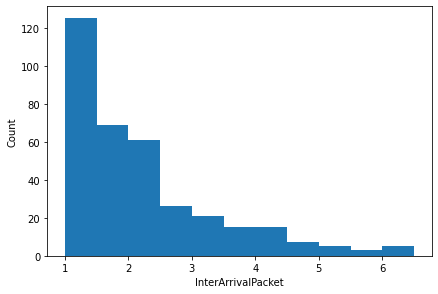

In [33]:
#Bins Configuration
bin_i=1
bin_f=7
bin_step=0.5

#x = np.diff(np.array((dfTxTimeFloat))*1e9,axis=0)
x = abs(np.diff(np.array(df)/1e6))/1e3
num_bins = np.arange(bin_i,bin_f,bin_step)
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins)
#ax=sns.distplot(x,kde=True,bins = num_bins)
n,bins=np.histogram(x,bins=num_bins)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
ax.set_xlabel('InterArrivalPacket')
ax.set_ylabel('Count')
plt.show()


#### Plotting Results - Fitagem

[-0.71093652  5.320588  ]


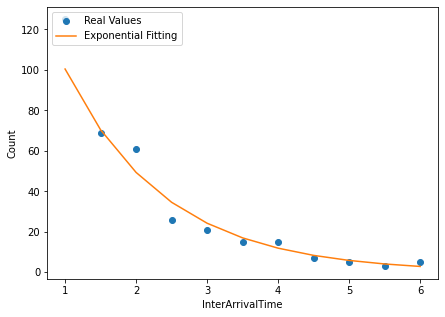

In [34]:
x_data = bins[:-1]
y_data = n

log_x_data = np.log(x_data)
log_y_data = np.log(y_data)
curve_fit = np.polyfit(x_data, log_y_data, 1)

print(curve_fit)

y = np.exp(curve_fit[1]) * np.exp(curve_fit[0]*x_data)


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(x_data, y_data, "o",label = "Real Values")
ax.plot(x_data, y,label = "Exponential Fitting")
ax.legend(loc="upper left")
ax.set_xlabel('InterArrivalTime')
ax.set_ylabel('Count')
plt.show()


## Desafio

### Desafio 1:  

Com base no código mostrado, crie **nsims** gráficos da prova de poisson, considerando todos os Jobs simulados. 

### Desafio 2:  

Com base no código mostrado, crie **nsims** gráficos, considerando a média de cada *nsim* e todos os Jobs. 

# Baseado no Código de Fitagem

[1.00000000e+00 1.77635684e-16]


<ipython-input-7-a9b4c5d1d232>:7: RuntimeWarning: divide by zero encountered in log
  log_x_data = np.log(x_data)


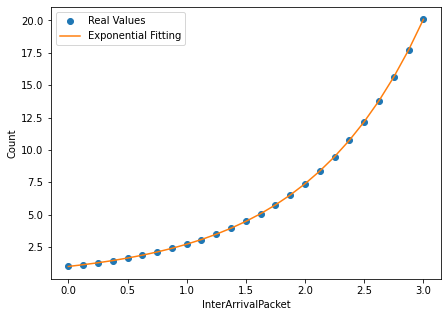

In [7]:
"""
Generate some data, let's imagine that you already have this. 
"""
x_data = np.linspace(0, 3, 25)
y_data = np.exp(x_data)

log_x_data = np.log(x_data)
log_y_data = np.log(y_data)
curve_fit = np.polyfit(x_data, log_y_data, 1)

print(curve_fit)

y = np.exp(curve_fit[1]) * np.exp(curve_fit[0]*x_data)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(x_data, y_data, "o",label = "Real Values")
ax.plot(x_data, y,label = "Exponential Fitting")
ax.legend(loc="upper left")
ax.set_xlabel('InterArrivalPacket')
ax.set_ylabel('Count')
plt.show()

